<a href="https://colab.research.google.com/github/Olofmeister007/Pytorch-Prac/blob/main/pytorch_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.datasets import make_circles

In [3]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [4]:
print(X.shape)
print(y.shape)
print(X[:5])
print(y[:5])

(1000, 2)
(1000,)
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:,0],
                        "X2" : X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


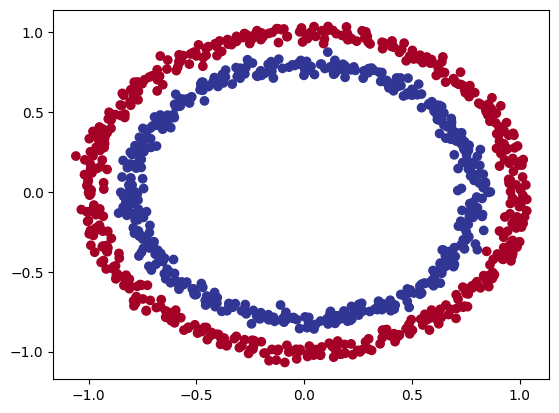

In [6]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [7]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)




In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20 % = test

In [12]:
import torch
from torch import nn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,5)
    self.layer_2 = nn.Linear(5,1)


  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [14]:
model0 = CircleModelV0().to(device)

In [15]:
next(model0.parameters()).device

device(type='cpu')

In [16]:
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5765,  0.6891],
                      [ 0.4381,  0.0222],
                      [-0.4439,  0.7023],
                      [ 0.0916,  0.6110],
                      [ 0.4193, -0.0196]])),
             ('0.bias', tensor([-0.4636, -0.5605, -0.4212,  0.5628, -0.4733])),
             ('1.weight',
              tensor([[ 0.1163,  0.4429, -0.3761,  0.1132,  0.2636]])),
             ('1.bias', tensor([-0.0594]))])

In [17]:
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))


print(f"first ten preds {untrained_preds[:10]}")
print(f"first ten test labels {y_test[:10]}")

first ten preds tensor([[-0.4951],
        [-0.3637],
        [-0.5211],
        [-0.4891],
        [-0.0153],
        [ 0.0610],
        [ 0.0303],
        [ 0.1310],
        [-0.5424],
        [-0.3493]])
first ten test labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [18]:
# for regression mse or mae
# for classification binary cross entropy or categorical cross entropy

# BCE(requires inputs to go through signmoid) and BCEWithlogits (sigmoid built in)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc
  #output = raw logits we can pass them to prediction probabilities by passing them through some activation function such as sigmoid then convert probabilityies to labels


In [21]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]
y_logits


tensor([[-0.4951],
        [-0.3637],
        [-0.5211],
        [-0.4891],
        [-0.0153]])

In [22]:
 y_pred_probs = torch.sigmoid(y_logits)
 y_pred_probs

tensor([[0.3787],
        [0.4101],
        [0.3726],
        [0.3801],
        [0.4962]])

In [24]:
y_preds = torch.round(y_pred_probs) # y >= 0.5, y=1, class 1  y<0.5, y=0, class 0
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [27]:
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5])) # Removing the call to y_pred_probs and using sigmoid directly
print(torch.eq(y_pred_labels.squeeze(), y_preds.squeeze())) # Compare to y_preds

tensor([True, True, True, True, True])


In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

In [31]:
epochs = 100

for epoch in range(epochs):
  model0.train()
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

 # loss = loss_fn(torch.sigmoid(y_logits), y_train) for BCELOSS

  loss = loss_fn(y_logits,y_train) #BCEWITHLOGITS Expects logits
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test_loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70945 | Acc: 47.50 | Test_loss: 0.71036 | Test Acc: 45.50
Epoch: 10 | Loss: 0.70163 | Acc: 49.88 | Test_loss: 0.70355 | Test Acc: 43.50
Epoch: 20 | Loss: 0.69837 | Acc: 49.50 | Test_loss: 0.70090 | Test Acc: 47.50
Epoch: 30 | Loss: 0.69667 | Acc: 49.00 | Test_loss: 0.69964 | Test Acc: 49.00
Epoch: 40 | Loss: 0.69565 | Acc: 49.88 | Test_loss: 0.69893 | Test Acc: 49.50
Epoch: 50 | Loss: 0.69498 | Acc: 50.50 | Test_loss: 0.69848 | Test Acc: 49.50
Epoch: 60 | Loss: 0.69452 | Acc: 50.00 | Test_loss: 0.69817 | Test Acc: 48.50
Epoch: 70 | Loss: 0.69420 | Acc: 49.88 | Test_loss: 0.69792 | Test Acc: 49.50
Epoch: 80 | Loss: 0.69396 | Acc: 50.12 | Test_loss: 0.69772 | Test Acc: 48.50
Epoch: 90 | Loss: 0.69378 | Acc: 50.38 | Test_loss: 0.69755 | Test Acc: 48.50


In [32]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


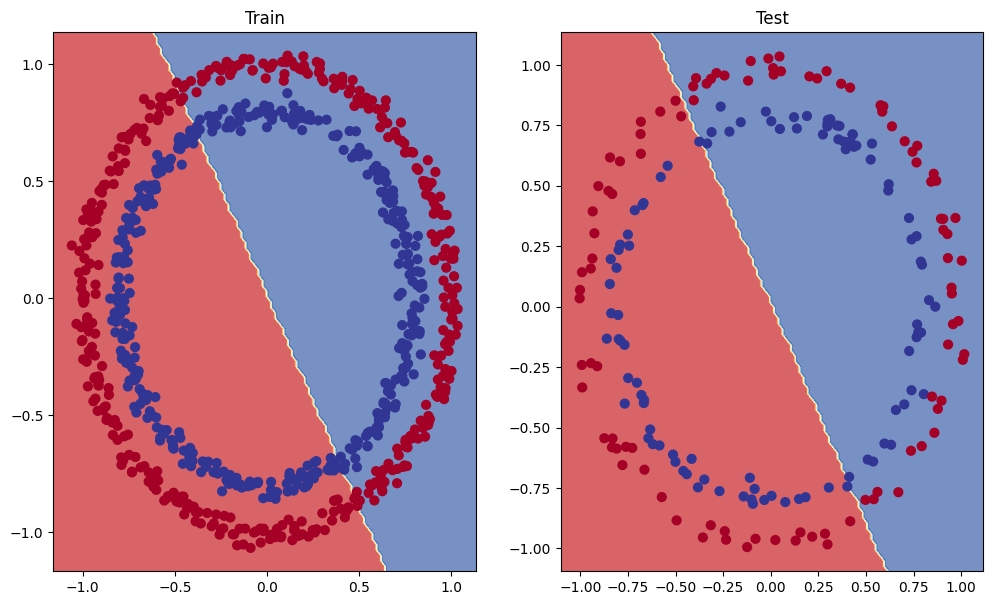

In [34]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

# LECTURE 77

In [ ]:
#improving a model from model perspective (epochs , activations functions, add more layers, add more hidden units, change learning rate, change loss function)
class CircleModelv1(nn.Module)